In [2]:
import numpy as np

In [2]:
from _segment import compute_cost

In [2]:
mat_dtype = np.dtype([('ks', np.int64), ('vs', np.float64)])

In [3]:
height = 1900
width = 1200

In [4]:
struct_mat = np.fromfile('/Users/bob/Downloads/word_map.bin', dtype=mat_dtype).reshape((width, height, -1))

In [5]:
image_ks = struct_mat['ks']
image_vs = struct_mat['vs']

In [6]:
image_ks.shape, image_vs.shape

((1200, 1900, 100), (1200, 1900, 100))

In [8]:
inner_size = image_ks.shape[2]

In [9]:
down_cost = compute_cost(
    image_ks[1:, :, :], image_vs[1:, :, :],
    image_ks[:-1, :, :], image_vs[:-1, :, :],
    inner_size
)
down_cost /= np.sum(down_cost)
right_cost = compute_cost(
    image_ks[:, 1:, :], image_vs[:, 1:, :],
    image_ks[:, :-1, :], image_vs[:, :-1, :],
    inner_size
)
right_cost /= np.sum(right_cost)
dright_cost = compute_cost(
    image_ks[1:, 1:, :], image_vs[1:, 1:, :],
    image_ks[:-1, :-1, :], image_vs[:-1, :-1, :],
    inner_size
)
dright_cost /= np.sum(dright_cost)
uright_cost = compute_cost(
    image_ks[1:, :-1, :], image_vs[1:, :-1, :],
    image_ks[:-1, 1:, :], image_vs[:-1, 1:, :],
    inner_size
)
uright_cost /= np.sum(uright_cost)

sum_cost = np.zeros((width, height))
sum_cost[:-1, :] += down_cost
sum_cost[:, :-1] += right_cost
sum_cost[:-1, :-1] += dright_cost
sum_cost[:-1, :-1] += uright_cost

In [10]:
from PIL import Image

In [11]:
np.amax(sum_cost), np.amin(sum_cost)

(0.005222321193574781, -0.00011825205746356511)

In [12]:
scaled_cost = (sum_cost + np.abs(np.amin(sum_cost))) / np.amax(sum_cost)

In [13]:
np.amax(scaled_cost), np.amin(scaled_cost)

(1.0226435818633781, 0.0)

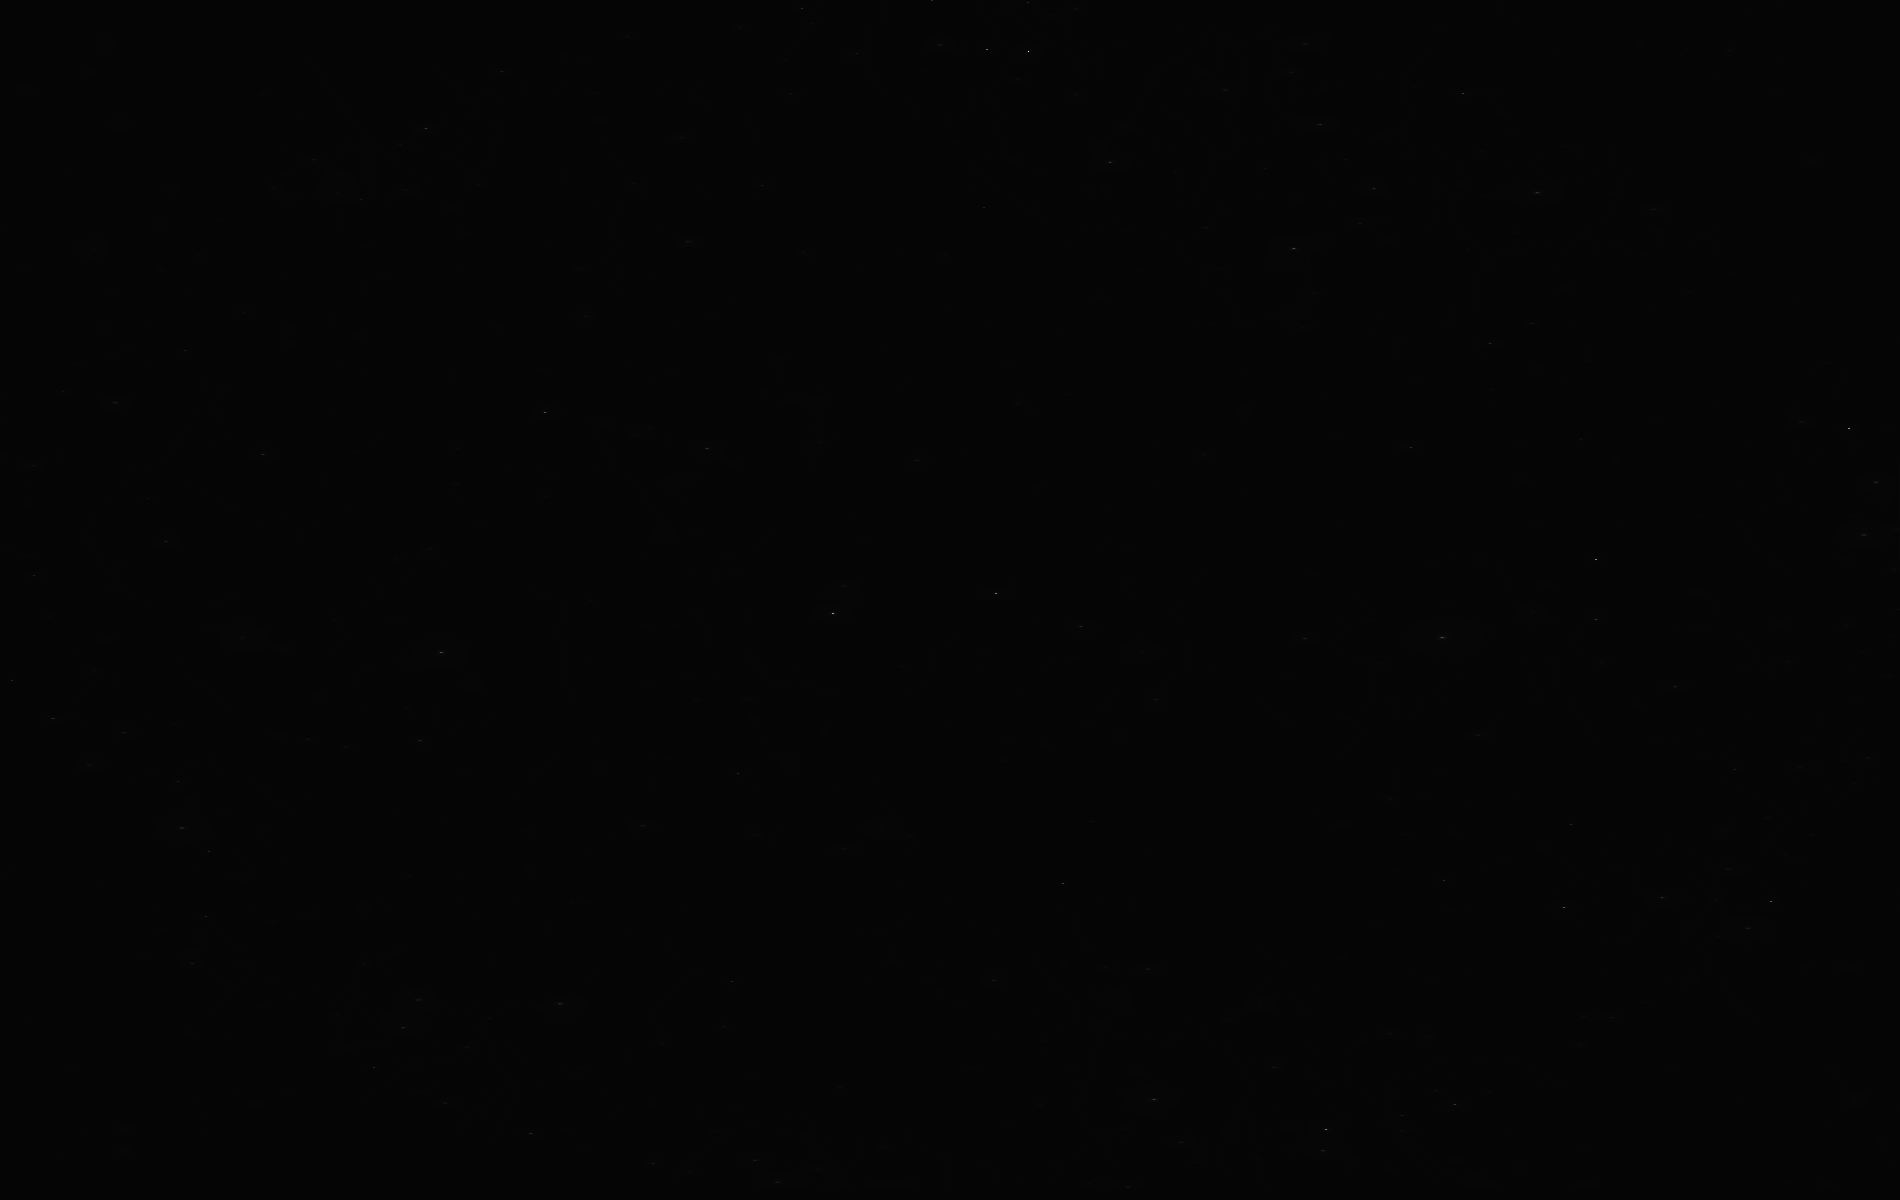

In [14]:
Image.fromarray(((scaled_cost.reshape((height, width))) * 255).astype(np.int8), mode='L')

In [131]:
mean_cost = np.mean(sum_cost)
sigma2_cost = np.std(sum_cost)
threshold = mean_cost + sigma2_cost

In [145]:
flat_cost = sum_cost.copy()
flat_cost[flat_cost > (mean_cost + sigma2_cost)] = threshold
flat_cost[flat_cost < (mean_cost)] = 0
flat_cost = (flat_cost + np.abs(np.amin(flat_cost))) / np.amax(flat_cost)

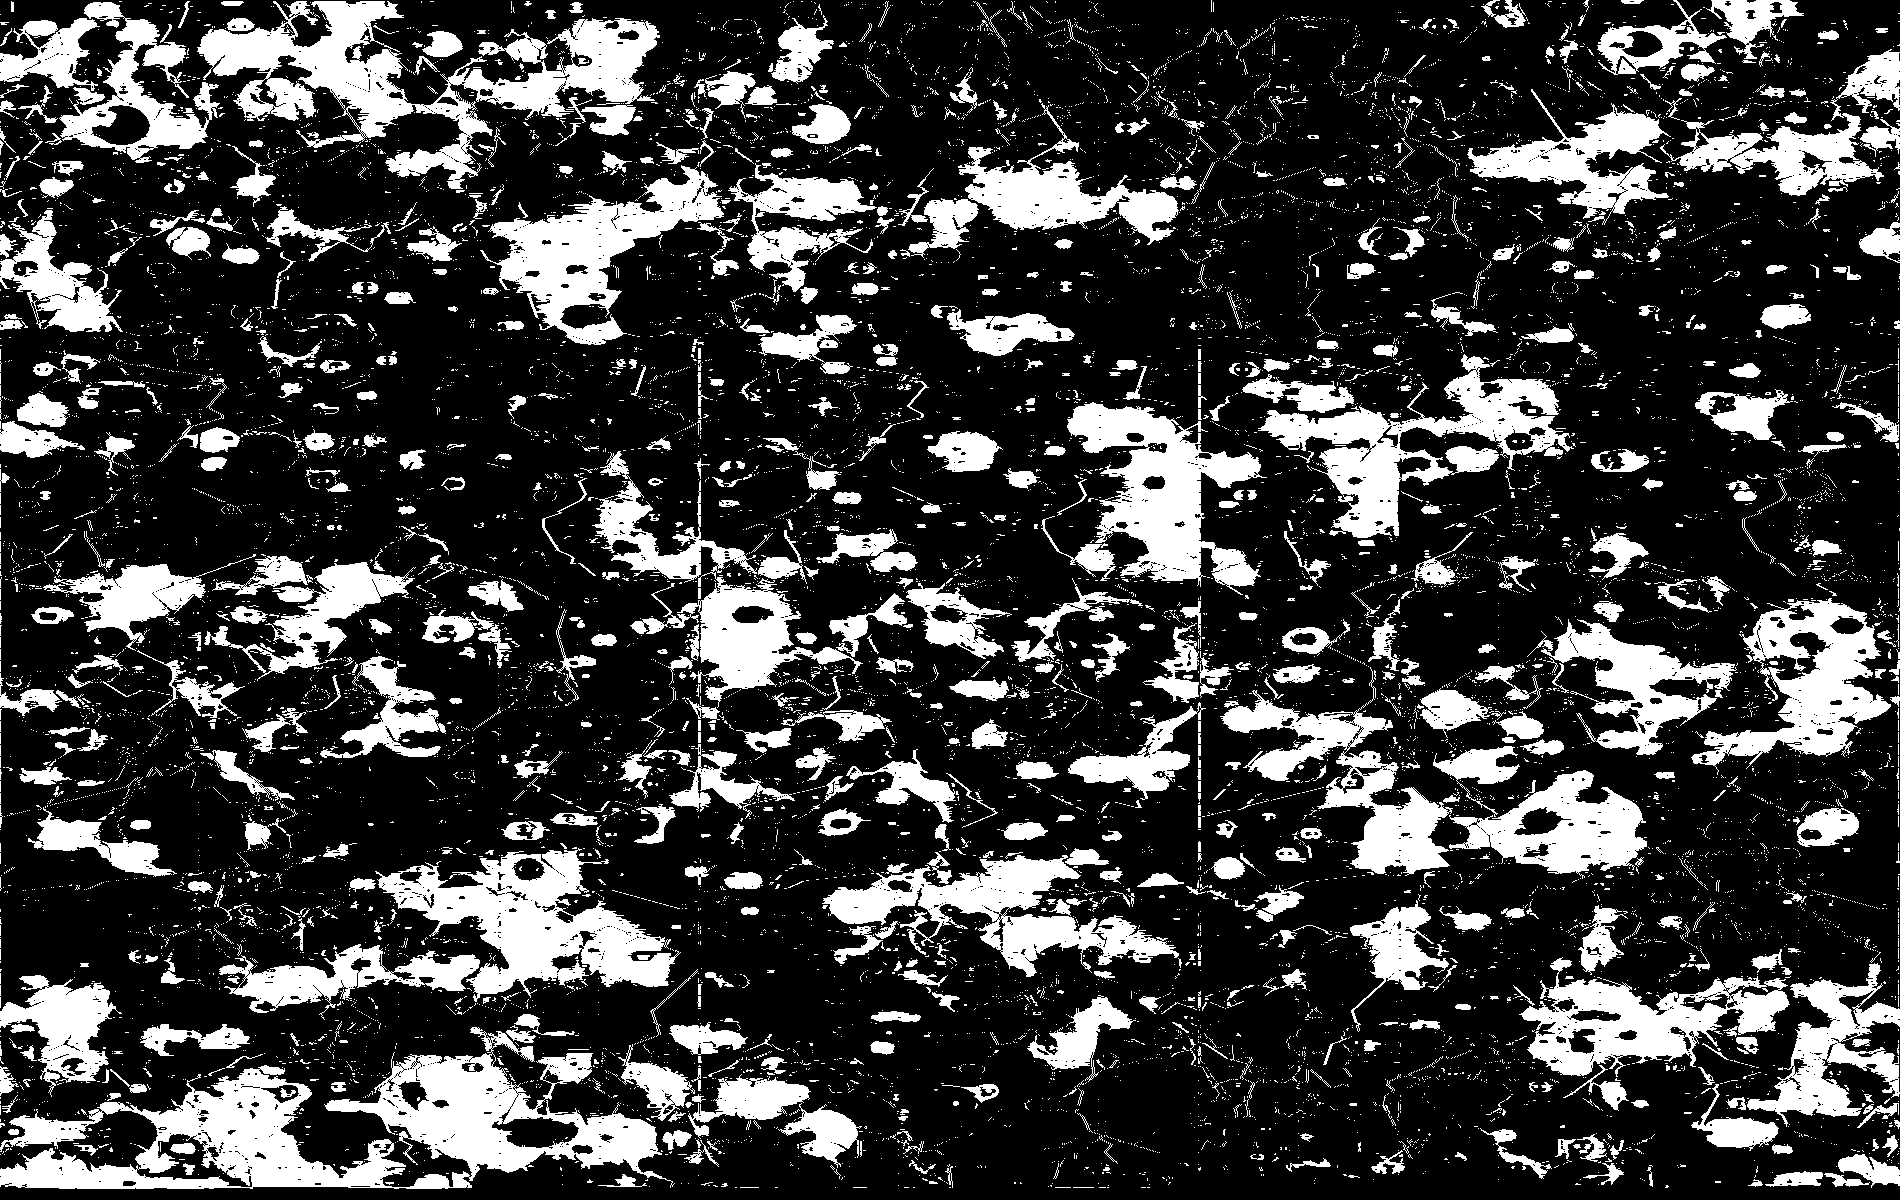

In [158]:
from skimage.filters import sobel, scharr
from skimage.feature import canny
Image.fromarray((canny(flat_cost) * 255).reshape((height, width)).astype(np.uint8), mode='L')

In [18]:
from skimage.transform import downscale_local_mean, rescale

In [19]:
scale = 100
means = rescale(downscale_local_mean(sum_cost, (scale,scale)), (scale,scale))

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [20]:
cont_cost = sum_cost / means

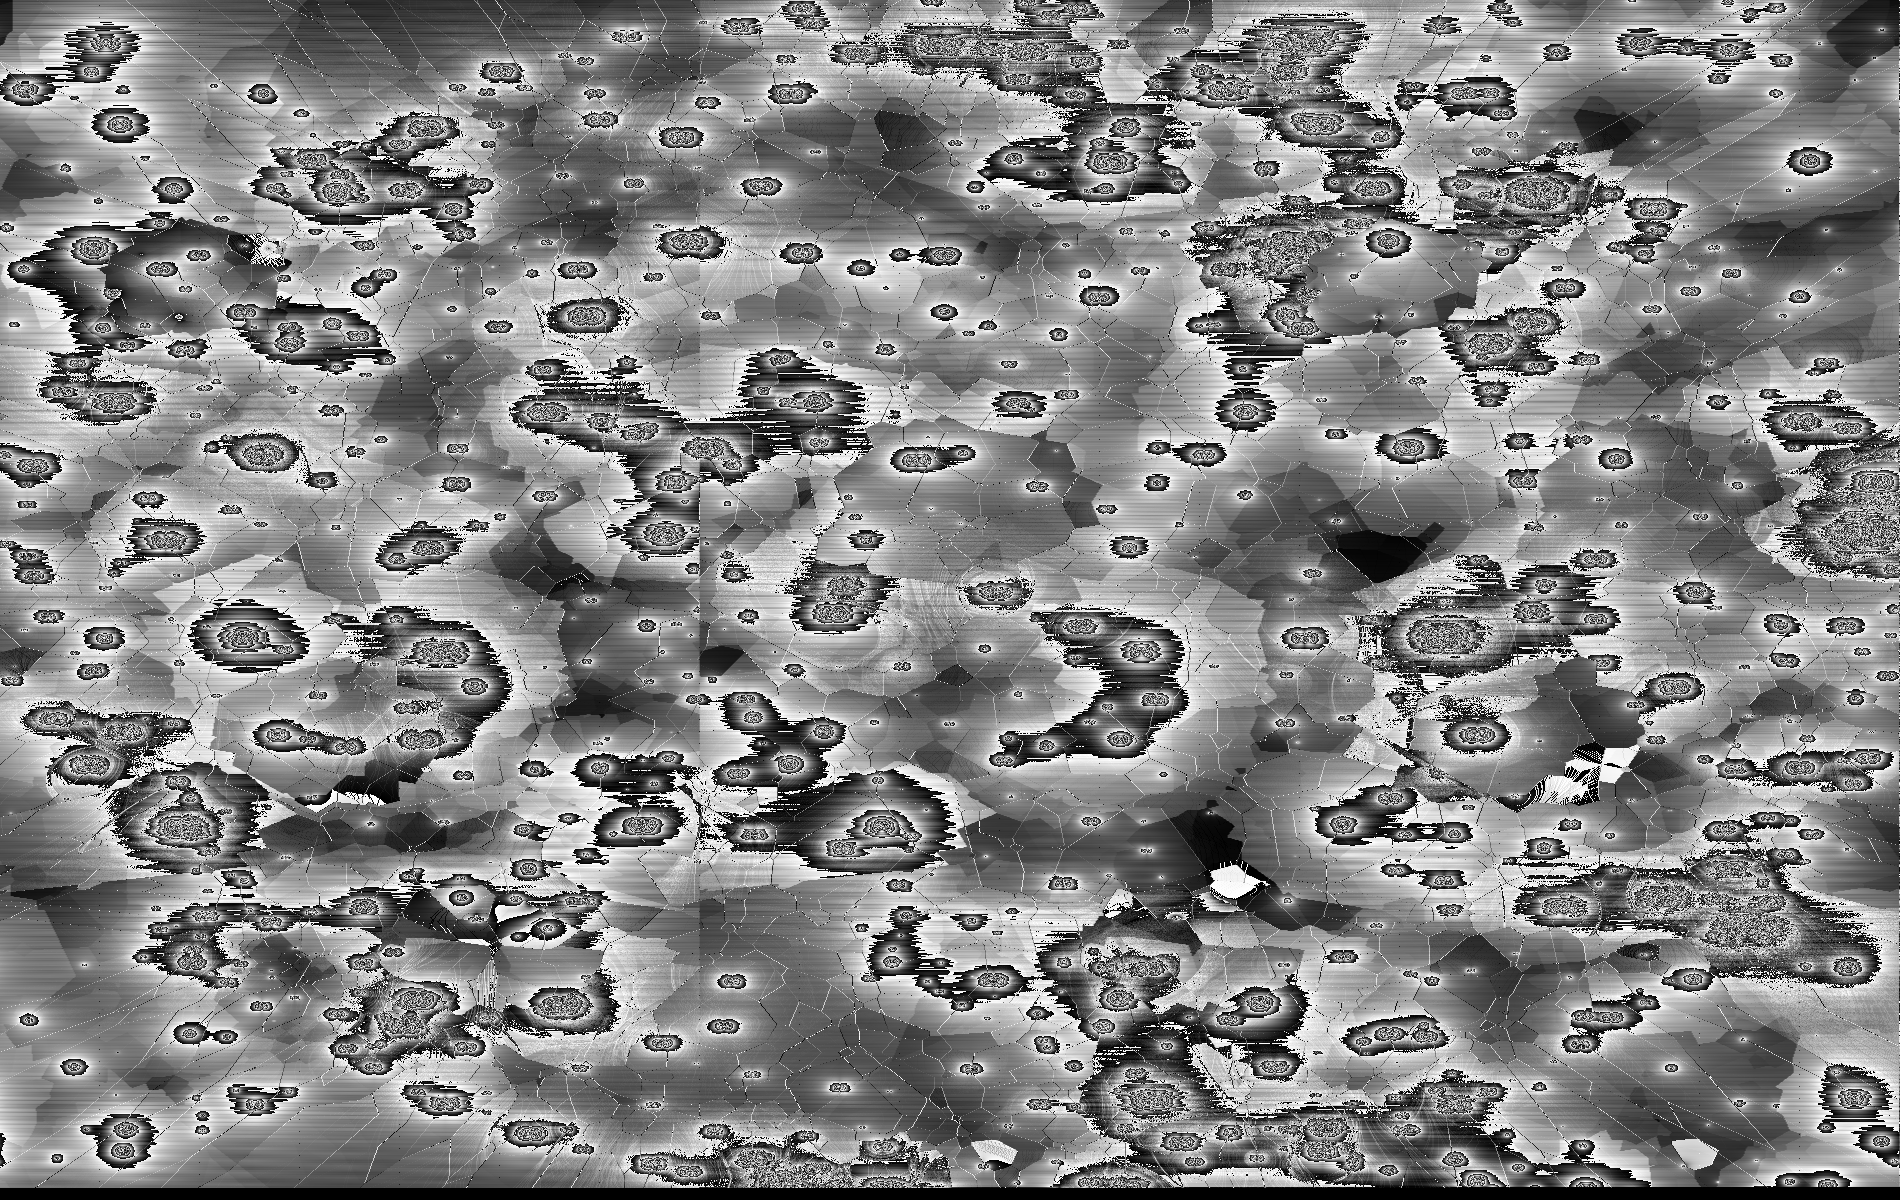

In [21]:
Image.fromarray((cont_cost * 255).reshape((height, width)).astype(np.uint8), mode='L')

In [22]:
cluster_centers = np.fromfile('/Users/bob/Downloads/clusters_2d.bin', dtype=np.float32).reshape((-1, 2))

In [23]:
cluster_centers.shape

(768, 2)

In [24]:

def scale(arr, target_x, target_y):
    min_x = np.min(arr[:, 0])
    min_y = np.min(arr[:, 1])
    max_x = np.max(arr[:, 0])
    max_y = np.max(arr[:, 1])
    factor_x = target_x / (max_x - min_x)
    factor_y = target_y / (max_y - min_y)
    res = np.zeros_like(arr)
    res[:, 0] = factor_x * (arr[:, 0] - min_x)
    res[:, 1] = factor_y * (arr[:, 1] - min_y)
    return res

scaled_cluster_centers = scale(cluster_centers, width, height)

In [25]:
scaled_cluster_centers

array([[1582.4358 ,  264.02957],
       [1003.90625,  325.57242],
       [ 463.012  ,  520.6554 ],
       ...,
       [ 708.1972 , 1131.7568 ],
       [1541.198  ,  890.4512 ],
       [ 511.4287 ,  966.84735]], dtype=float32)

In [27]:
from scipy.spatial import cKDTree as KDTree

In [28]:
tree = KDTree(scaled_cluster_centers)

In [92]:
xx, yy = np.meshgrid(np.arange(width), np.arange(height))
distances, neighbors = tree.query(np.transpose((xx, yy)), k=1)

In [100]:
np.amax(distances), np.amin(distances)

(309.32956721149975, 0.0031874437981680957)

In [88]:
neighbors.shape

(1900, 1200)

In [89]:
#distances = np.log(distances)

In [143]:
distance_weighted_cost = sum_cost / (distances / np.amax(distances))**2
#mean_cost = np.mean(distance_weighted_cost)
#sigma2_cost = np.std(distance_weighted_cost)
#threshold = mean_cost + 2*sigma2_cost
#distance_weighted_cost[distance_weighted_cost > (mean_cost + sigma2_cost)] = 0
#distance_weighted_cost[distance_weighted_cost < (mean_cost)] = 0
#distance_weighted_cost = (distance_weighted_cost + np.abs(np.amin(distance_weighted_cost))) / np.amax(distance_weighted_cost)

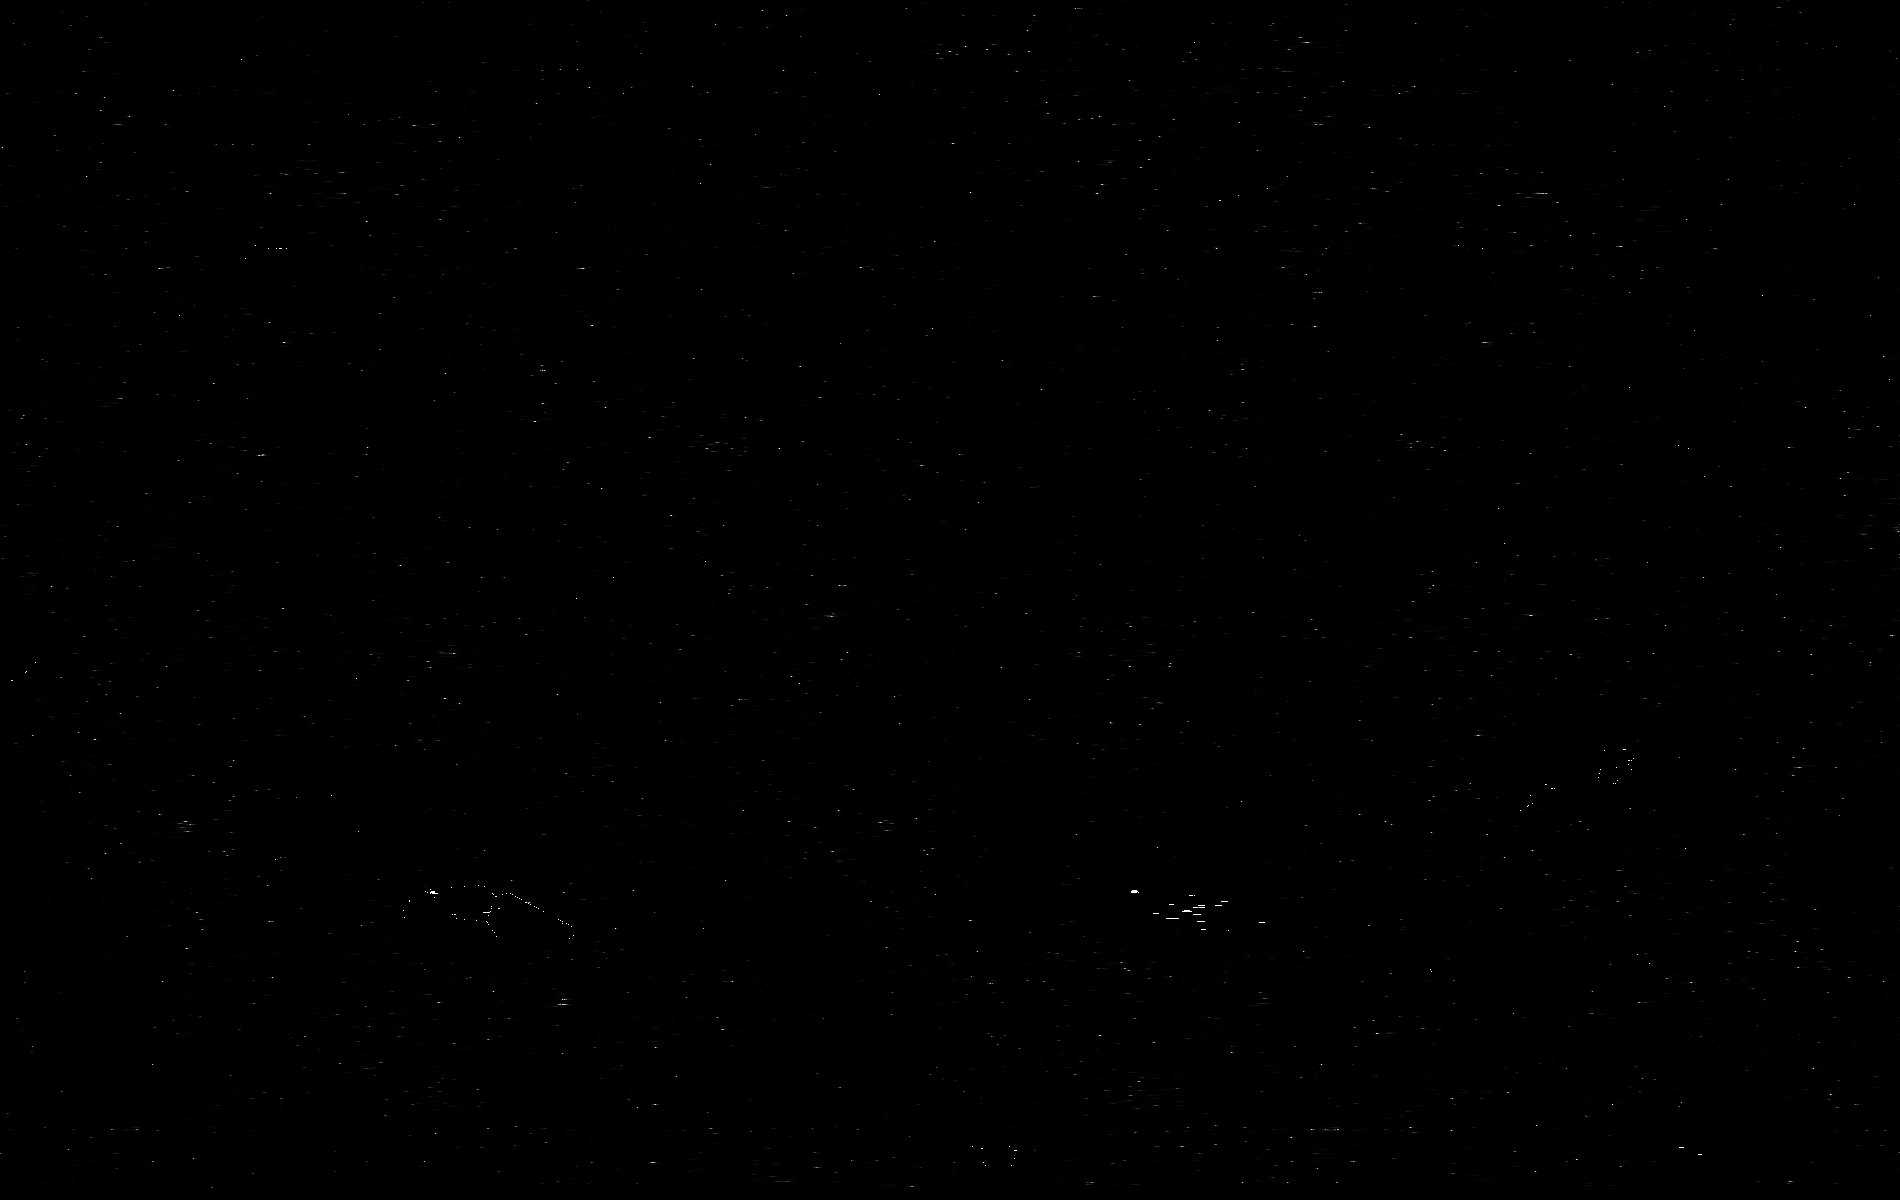

In [144]:
Image.fromarray((distance_weighted_cost * 255).reshape((height, width)).astype(np.uint8), mode='L')

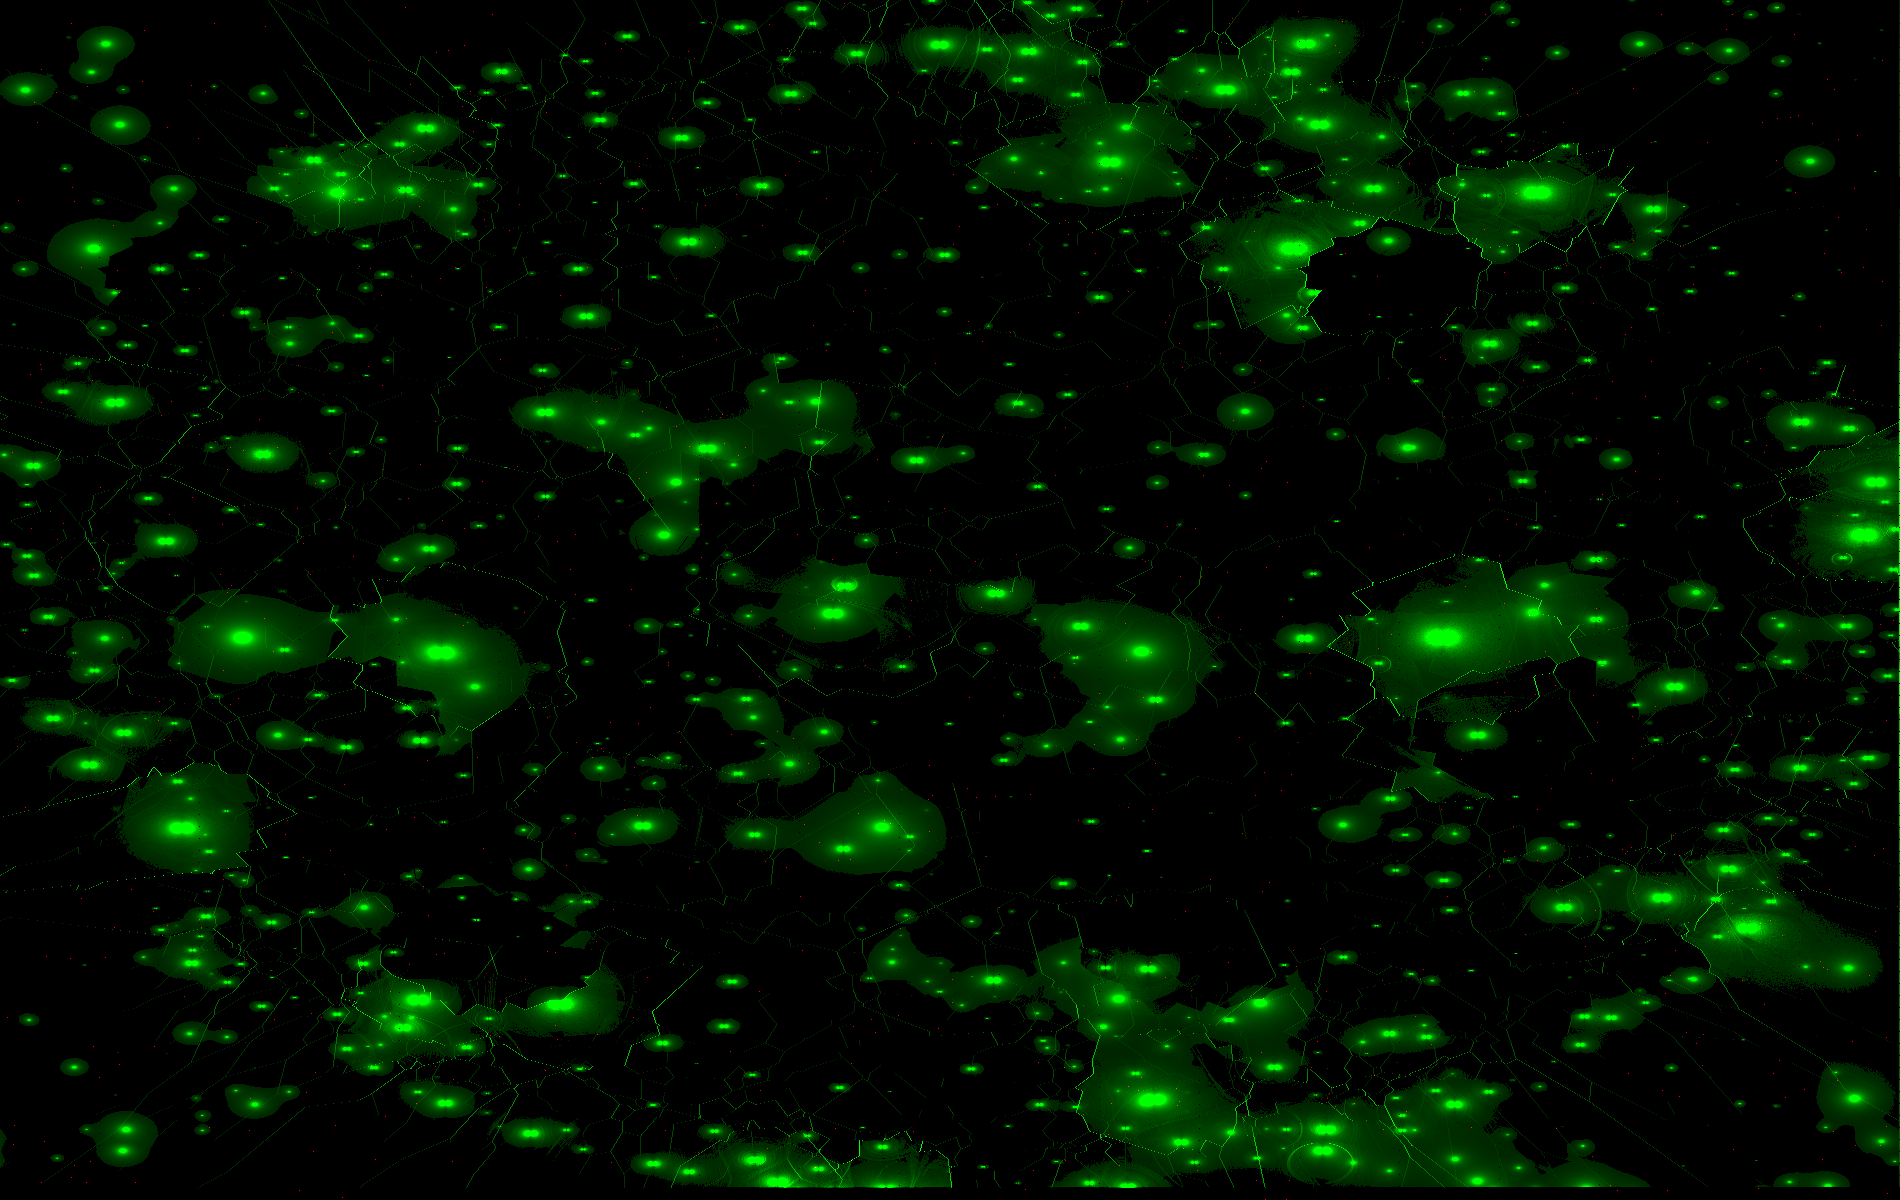

In [154]:
coord_colored = np.zeros((width, height, 3), dtype=np.uint8)
coord_colored[:, :, 1] = (flat_cost * 255).astype(np.uint8)
cluster_coords = scaled_cluster_centers.astype(np.uint64) - 1
coord_colored[cluster_coords[:, 0], cluster_coords[:, 1], 0] = 255
Image.fromarray(coord_colored.reshape((height, width, 3)), mode='RGB')

In [7]:
import quickshift

In [4]:
#labels = quickshift._quickshift_cython(image_ks, image_vs, 5, 2, False, 42)
labels = np.fromfile('word_labels.bin', dtype=np.int64).reshape((width, height))

In [5]:
labels.shape

(1200, 1900)

In [6]:
uniq_labels = np.unique(labels)

In [7]:
uniq_labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [25]:
colors = np.random.randint(0, 255, uniq_labels.shape[0])

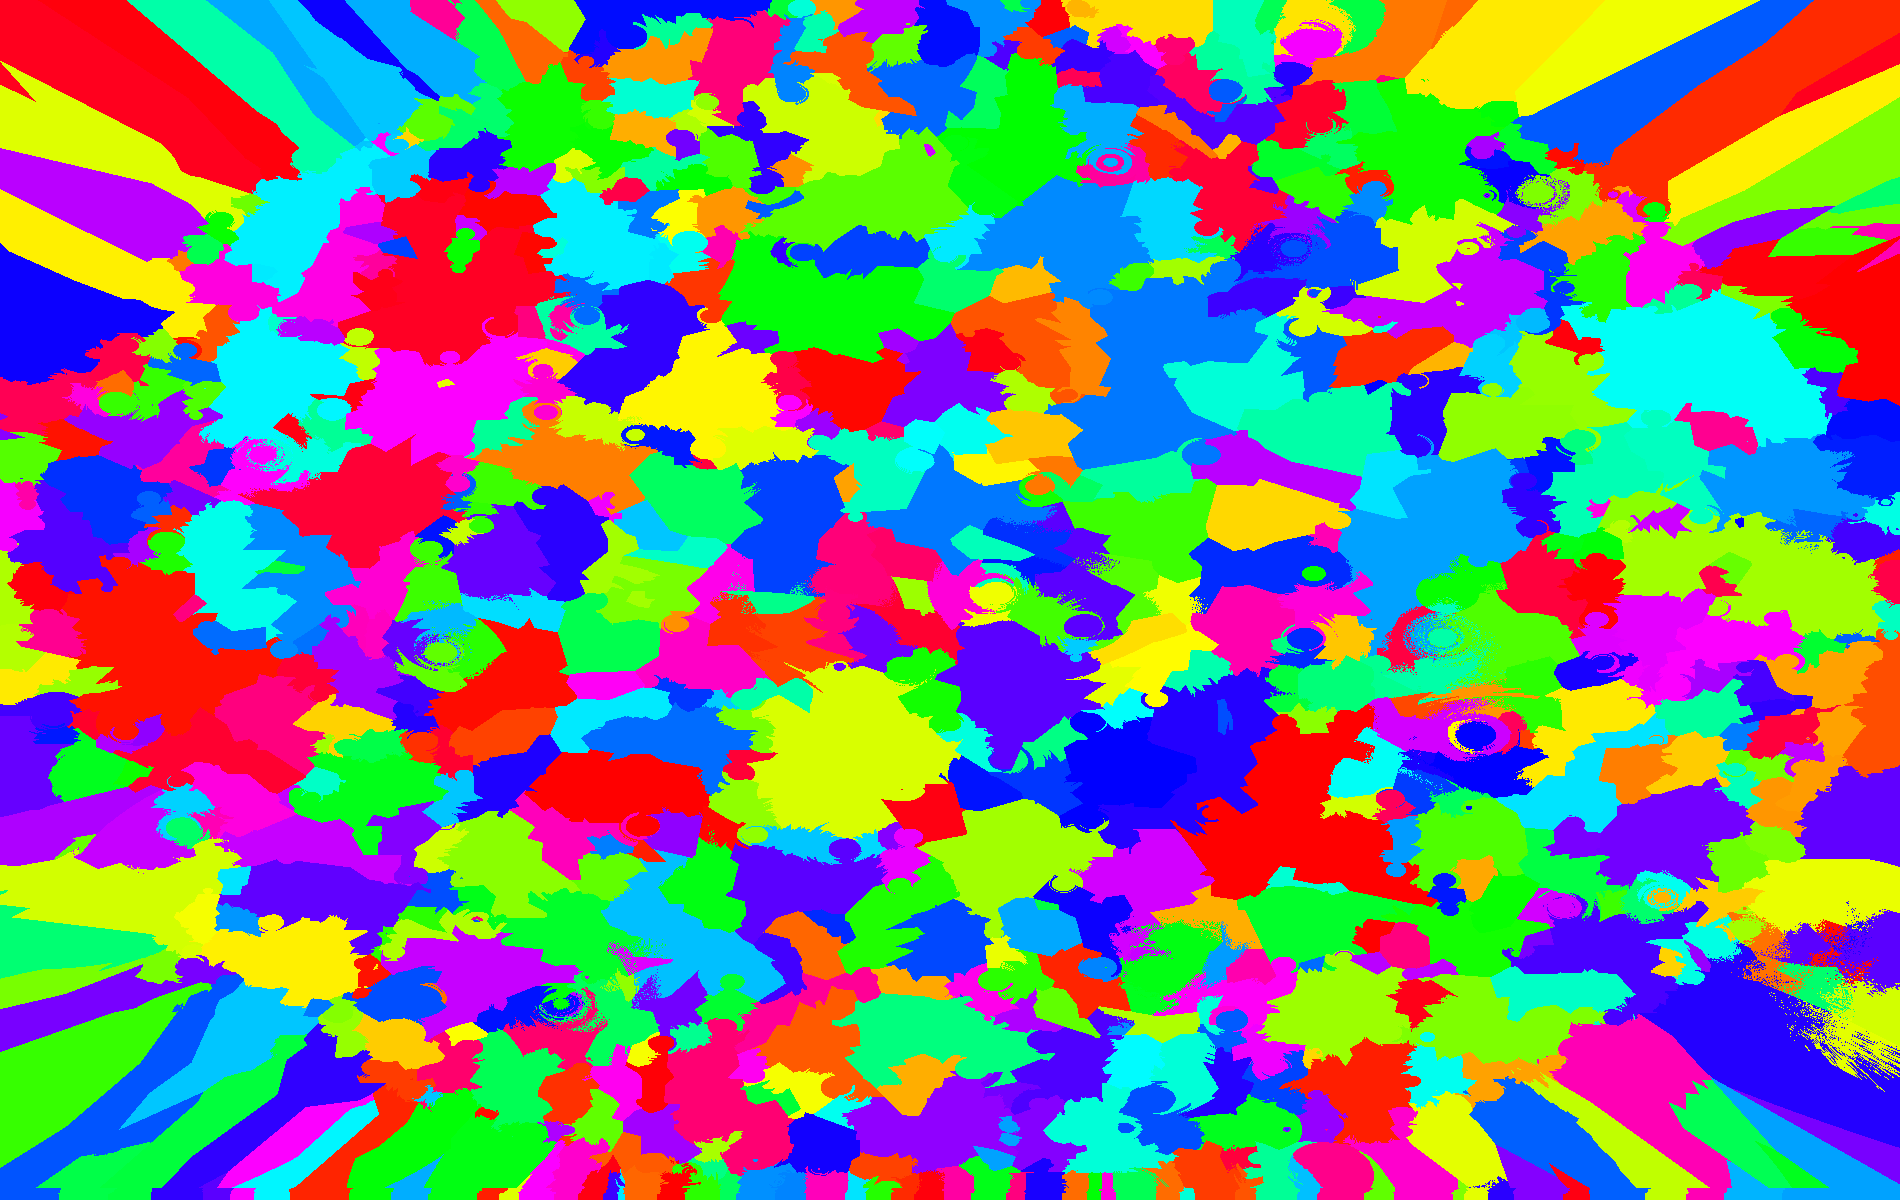

In [10]:
from PIL import Image
color_coded = np.zeros((width, height, 3), dtype=np.uint8)
color_coded[:, :, 0] = colors[labels]
color_coded[:, :, 1] = 255
color_coded[:, :, 2] = 255
Image.fromarray(color_coded, mode='HSV').convert('RGB')

In [32]:
ck_colors = np.array([
(0x47,0x49,0x51),
(0x8a,0x7b,0x5e),
(0x72,0x52,0x4e),
(0x7a,0x38,0x4e),
(0x57,0x47,0x7e),
(0x6a,0x7f,0x70),
(0x58,0x83,0x55),
(0xf1,0xc3,0x86),
(0x95,0x59,0x4b),
(0x30,0x3e,0x29)], dtype=np.uint8)

colors_size = uniq_labels.shape[0]
colors = np.empty((colors_size, 3), dtype=np.uint8)
colors[:, 0] = np.random.randint(np.amin(ck_colors[:, 0]), np.amax(ck_colors[:, 0]), colors_size)
colors[:, 1] = np.random.randint(np.amin(ck_colors[:, 1]), np.amax(ck_colors[:, 1]), colors_size)
colors[:, 2] = np.random.randint(np.amin(ck_colors[:, 2]), np.amax(ck_colors[:, 2]), colors_size)

In [15]:
labels_clean = labels.copy()
window_size_x = 10
window_size_y = 10
for r in range(width-window_size_x):
    for c in range(height-window_size_y):
        window = labels_clean[r:(r + window_size_x), c:(c + window_size_y)]
        vals, counts = np.unique(window, return_counts=True)
        target_val = vals[np.argmax(counts)]
        labels_clean[r, c] = target_val

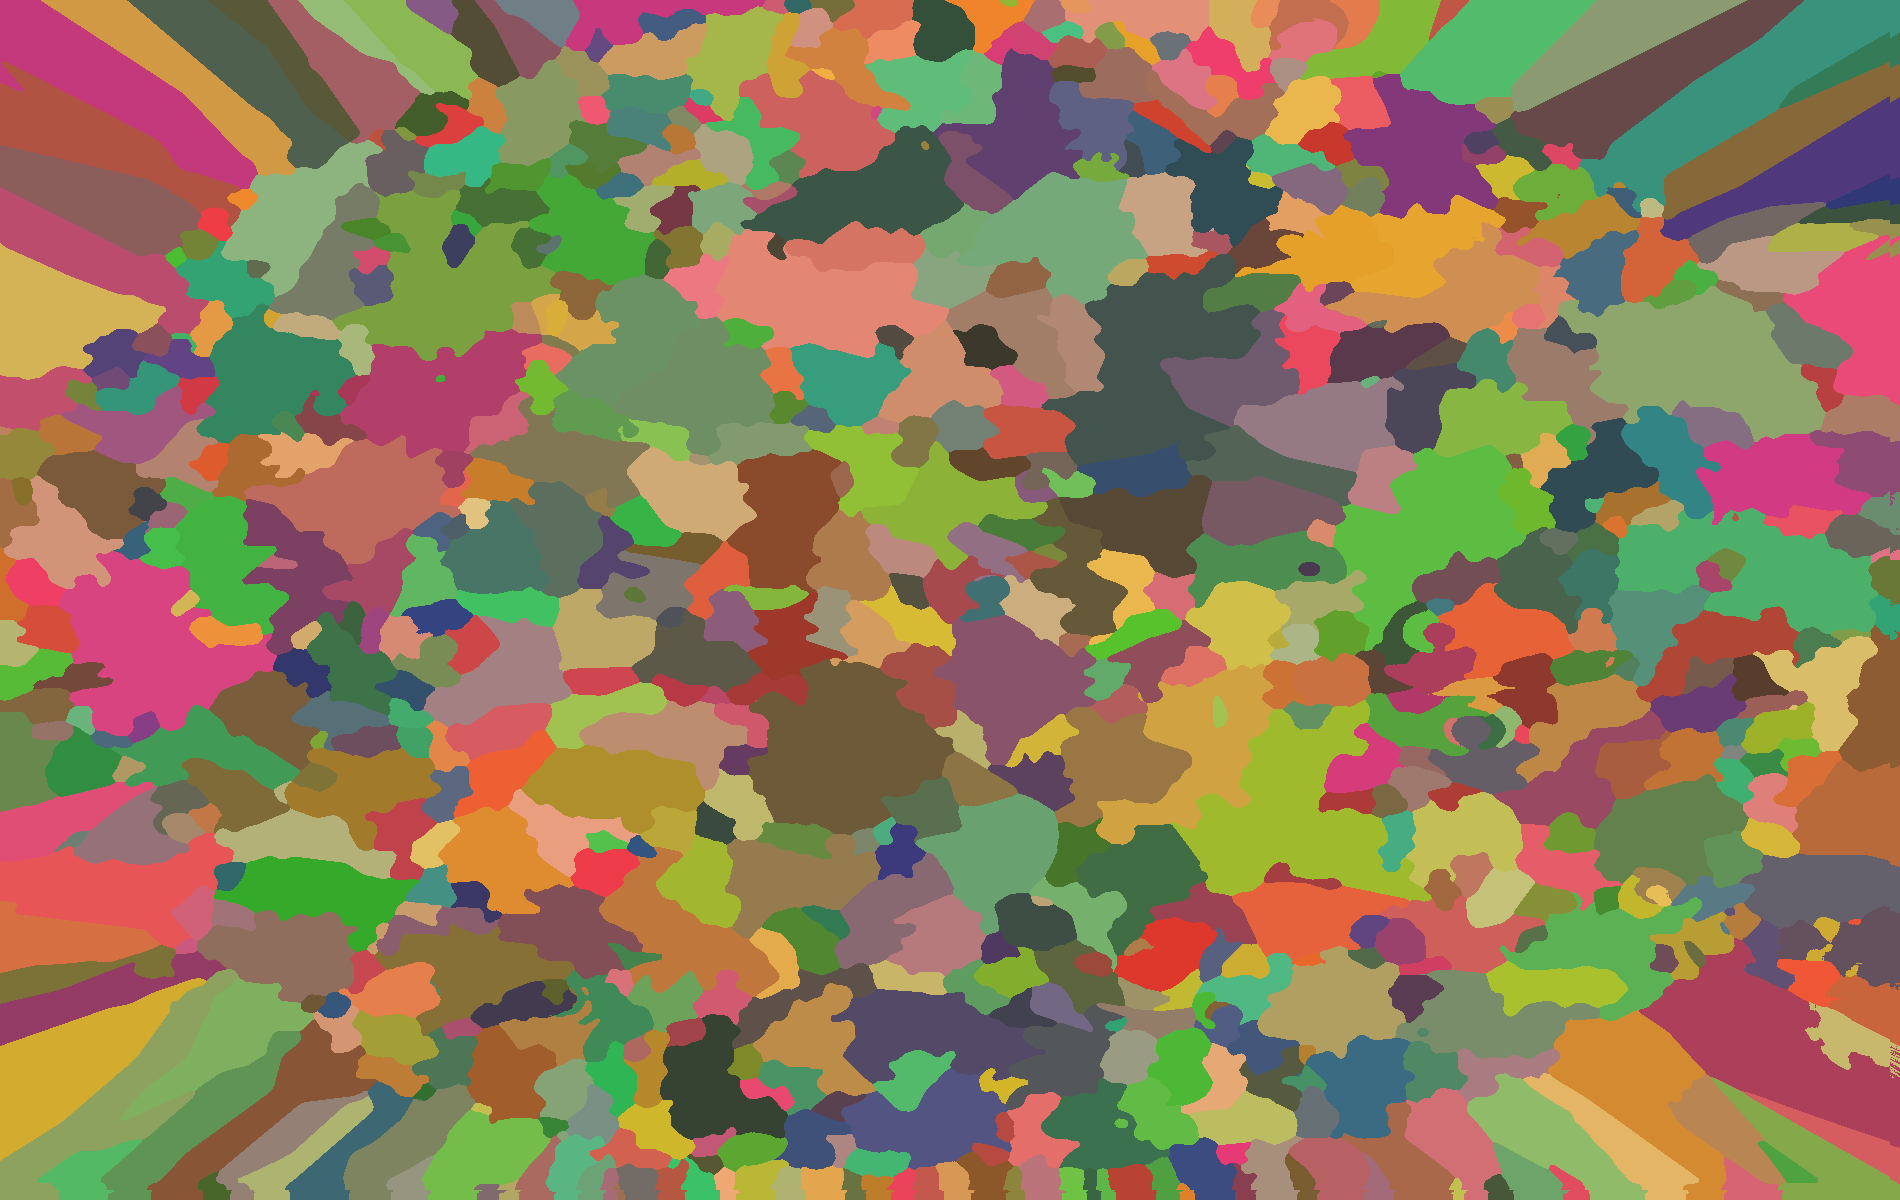

In [33]:
from PIL import Image
color_coded = np.zeros((width, height, 3), dtype=np.uint8)
color_coded[:, :, 0] = colors[labels_clean, 0]
color_coded[:, :, 1] = colors[labels_clean, 1]
color_coded[:, :, 2] = colors[labels_clean, 2]
Image.fromarray(color_coded, mode='RGB')